In [ ]:
%matplotlib inline
from google.colab import drive
import pickle
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import joblib
import time

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset ...
#  You will need to seperately download or generate this file
#Xd = pickle.load(open("/content/drive/MyDrive/RML2016.10a_dict.pkl",'rb'))
Xd = pickle.load(open("/content/drive/MyDrive/RML2016.10a_dict.pkl",'rb'),encoding = "bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test = X[test_idx]


lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]


[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


# Build the NN Model

In [ ]:
model = models.Sequential()
model.add(Reshape(in_shp + [1], input_shape = in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(256, (1, 3), activation ='relu'))
model.add(Dropout(0.5))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(80, (2, 3), activation ='relu'))
model.add(Dropout(0.5))
#model.add(Conv2D(16, (1, 4), activation ='relu'))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation ='relu')) # 128
model.add(Dropout(0.5))
model.add(Dense(128, activation ='relu')) # 128
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation ='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 2, 132, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 2, 130, 256)       1024      
                                                                 
 dropout (Dropout)           (None, 2, 130, 256)       0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 2, 134, 256)       0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 132, 80)        1

In [ ]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
tic = time.time()
history = model.fit(X_train,
                    y_train,
                    batch_size = 1024,
                    epochs = 100,
                    verbose = 1,
                    validation_data = (X_test, y_test),
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1,
                                               mode = 'auto', restore_best_weights = True)])
toc = time.time()
training_time = toc - tic

print ("The training time is %.3f seconds" %(training_time))

Epoch 1/100
108/108 [==============================] - 21s 132ms/step - loss: 2.2601 - accuracy: 0.1395 - val_loss: 2.1224 - val_accuracy: 0.2039
Epoch 2/100
108/108 [==============================] - 13s 119ms/step - loss: 2.0631 - accuracy: 0.2268 - val_loss: 1.9426 - val_accuracy: 0.2647
Epoch 3/100
108/108 [==============================] - 13s 119ms/step - loss: 1.9200 - accuracy: 0.2788 - val_loss: 1.7849 - val_accuracy: 0.3424
Epoch 4/100
108/108 [==============================] - 13s 120ms/step - loss: 1.7666 - accuracy: 0.3387 - val_loss: 1.5655 - val_accuracy: 0.4164
Epoch 5/100
108/108 [==============================] - 13s 120ms/step - loss: 1.6313 - accuracy: 0.3835 - val_loss: 1.4743 - val_accuracy: 0.4405
Epoch 6/100
108/108 [==============================] - 13s 120ms/step - loss: 1.5536 - accuracy: 0.4070 - val_loss: 1.4941 - val_accuracy: 0.4262
Epoch 7/100
108/108 [==============================] - 13s 121ms/step - loss: 1.5113 - accuracy: 0.4208 - val_loss: 1.4015 -

In [ ]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3438/3438 [==============================] - 145s 42ms/step - loss: 2.3979 - accuracy: 0.0925
Test loss: 2.3978991508483887
Test accuracy: 0.09253636002540588


In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict, axis = 1)))

3438/3438 [==============================] - 10s 3ms/step
              precision    recall  f1-score   support

           0       0.40      0.52      0.45      9991
           1       0.55      0.68      0.61     10041
           2       0.26      0.92      0.40      9915
           3       0.81      0.60      0.69      9841
           4       0.74      0.62      0.67     10076
           5       0.78      0.61      0.68     10067
           6       0.93      0.64      0.76     10086
           7       0.34      0.02      0.04     10024
           8       0.52      0.66      0.58      9920
           9       0.81      0.23      0.36      9998
          10       0.66      0.18      0.28     10041

    accuracy                           0.52    110000
   macro avg       0.62      0.52      0.50    110000
weighted avg       0.62      0.52      0.50    110000



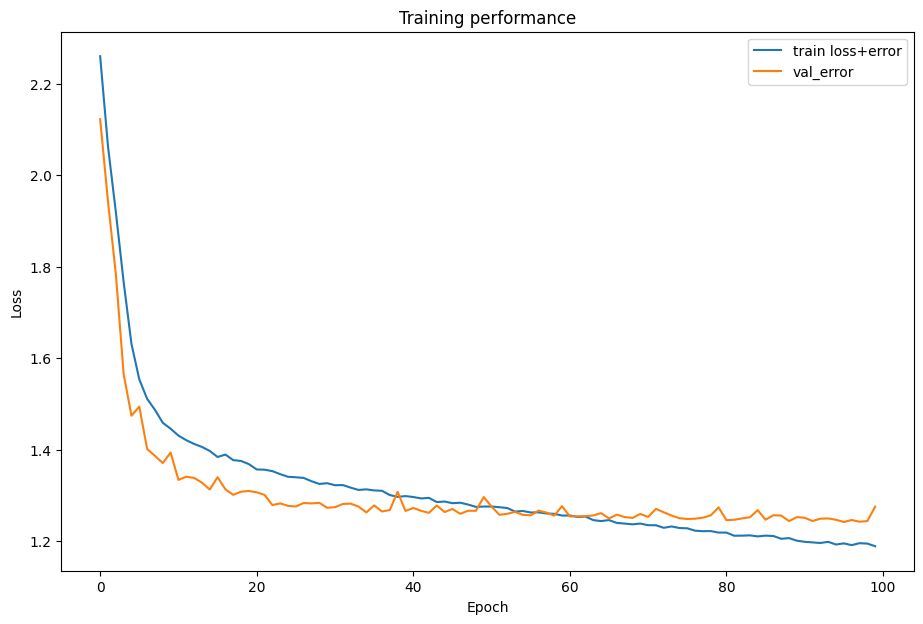

In [ ]:
plt.figure(figsize = (11, 7))
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label = 'train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap = plt.cm.Blues, labels = []):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def confusion_matrix(model, classes, X_test, y_test):
    test_Y_hat = model.predict(X_test, batch_size = 1024)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, X_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(test_Y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, labels = classes)


108/108 [==============================] - 2s 22ms/step


ValueError: left cannot be >= right

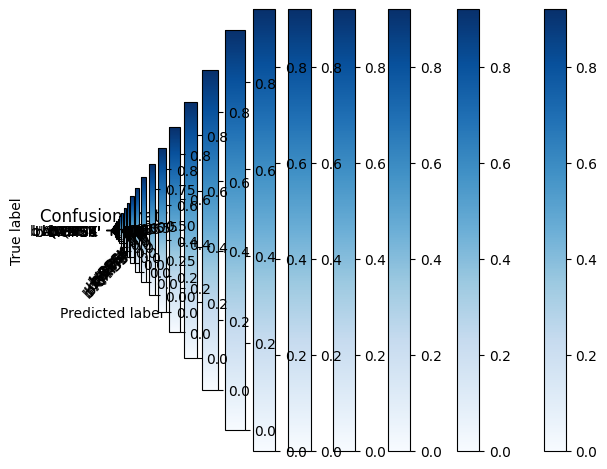

In [ ]:
confusion_matrix(model, classes, X_test, y_test)

In [ ]:
def getTestAccArray(model, lbl, X_test, y_test, test_idx):
    acc = []

    snr_array=np.asarray(lbl)[:,1]
    lb_temp = preprocessing.LabelBinarizer()
    lb_temp.fit(snr_array)
    temp_array=lb_temp.classes_
    snr_label_array = []
    test_SNRs=snr_array[test_idx]

    snr_label_array.append(temp_array[6])
    snr_label_array.append(temp_array[4])
    snr_label_array.append(temp_array[3])
    snr_label_array.append(temp_array[2])
    snr_label_array.append(temp_array[1])
    snr_label_array.append(temp_array[0])
    snr_label_array.append(temp_array[9])
    snr_label_array.append(temp_array[8])
    snr_label_array.append(temp_array[7])
    snr_label_array.append(temp_array[5])
    snr_label_array.append(temp_array[10])
    snr_label_array.append(temp_array[16])
    snr_label_array.append(temp_array[17])
    snr_label_array.append(temp_array[18])
    snr_label_array.append(temp_array[19])
    snr_label_array.append(temp_array[11])
    snr_label_array.append(temp_array[12])
    snr_label_array.append(temp_array[13])
    snr_label_array.append(temp_array[14])
    snr_label_array.append(temp_array[15])

    for snr in snr_label_array:
        test_X_i = X_test[np.where(test_SNRs==snr)]
        test_Y_i = y_test[np.where(test_SNRs==snr)]
        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes), len(classes)])
        confnorm = np.zeros([len(classes), len(classes)])

        for i in range(0, test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1

        for i in range(0, len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        plt.figure()
        SNR_value = snr.astype('int')
        plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(SNR_value))
        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
        acc.append(1.0*cor/(cor+ncor))

    return acc

174/174 [==============================] - 1s 3ms/step
Overall Accuracy:  0.09213362068965517 for SNR b'-20'
172/172 [==============================] - 1s 3ms/step
Overall Accuracy:  0.09308267932104398 for SNR b'-18'
174/174 [==============================] - 1s 3ms/step
Overall Accuracy:  0.09700685178507032 for SNR b'-16'
171/171 [==============================] - 0s 3ms/step
Overall Accuracy:  0.10204828090709583 for SNR b'-14'
175/175 [==============================] - 0s 2ms/step
Overall Accuracy:  0.13458445040214478 for SNR b'-12'
170/170 [==============================] - 0s 2ms/step
Overall Accuracy:  0.22310097480228067 for SNR b'-10'
169/169 [==============================] - 0s 2ms/step
Overall Accuracy:  0.3245192307692308 for SNR b'-8'
172/172 [==============================] - 0s 2ms/step
Overall Accuracy:  0.4788964005116024 for SNR b'-6'
175/175 [==============================] - 0s 2ms/step
Overall Accuracy:  0.617604876299749 for SNR b'-4'
173/173 [=================

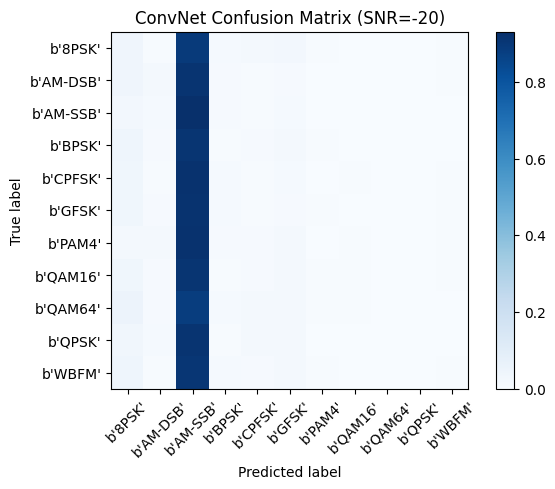

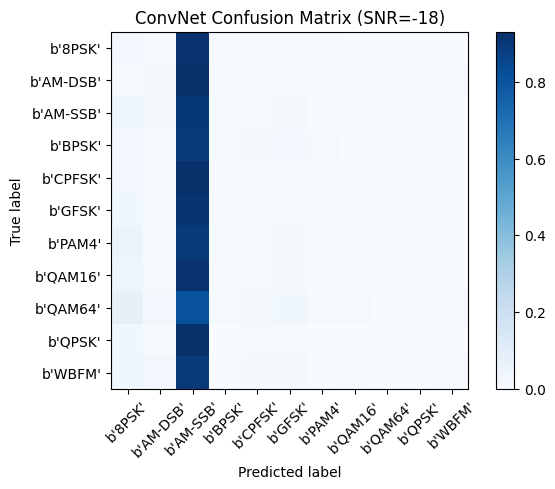

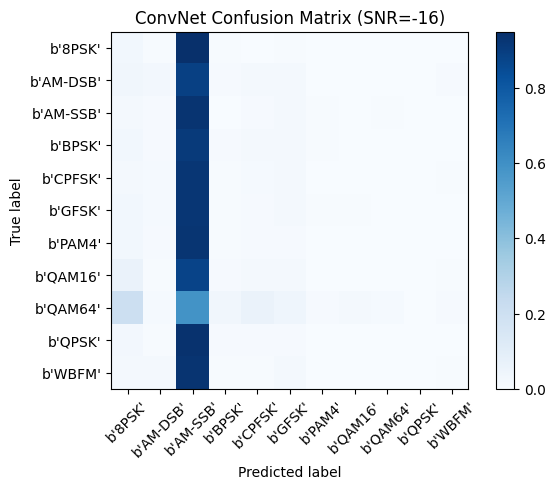

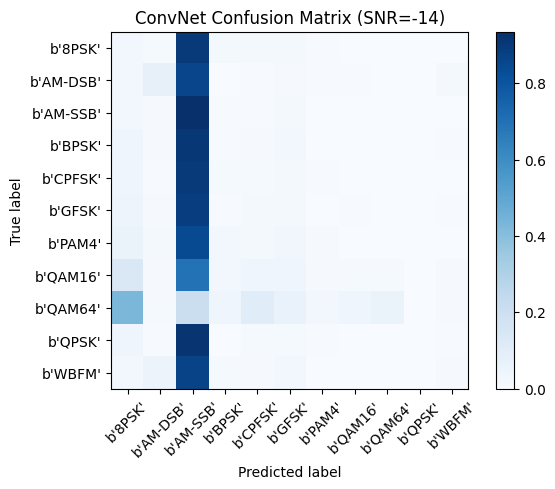

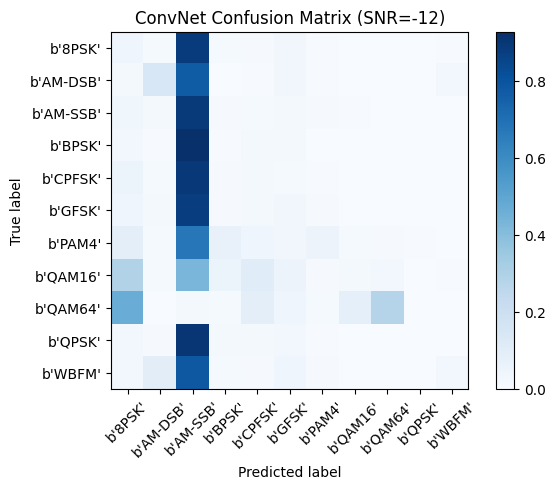

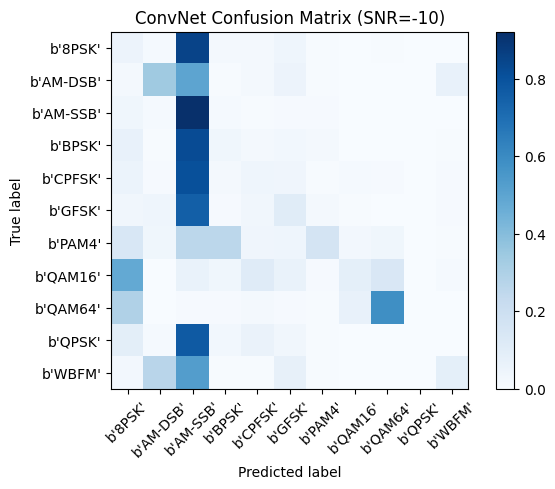

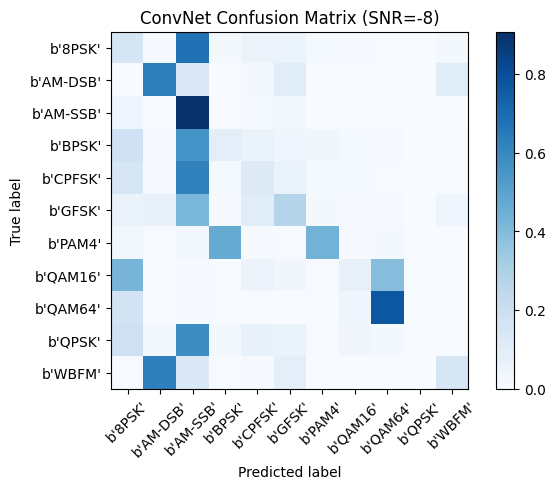

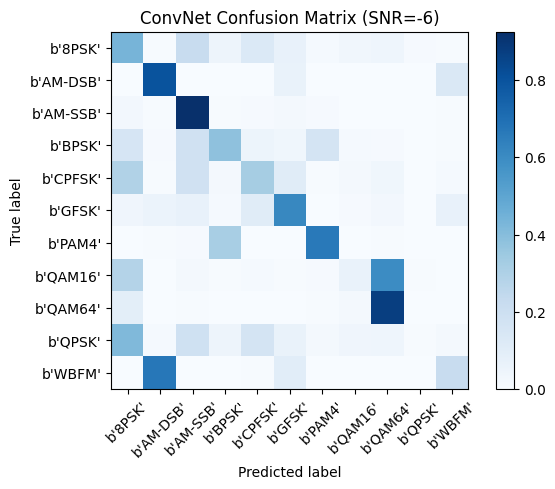

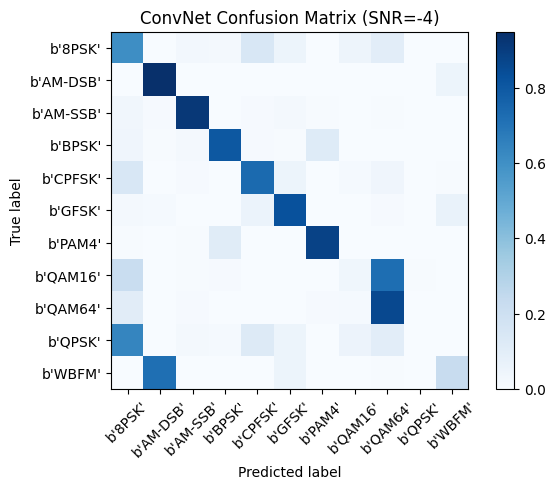

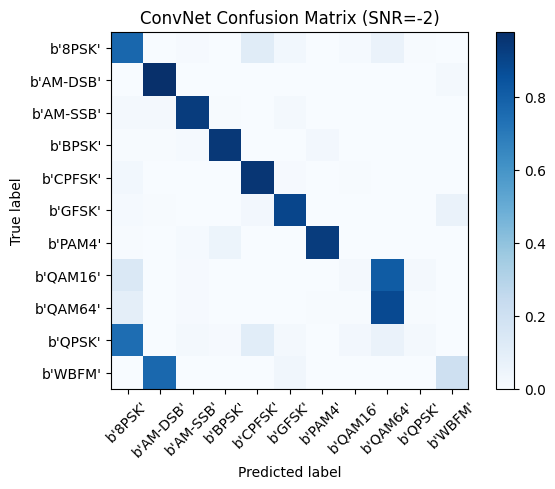

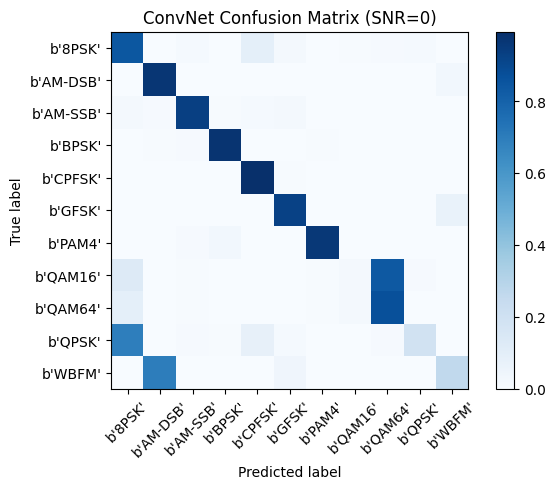

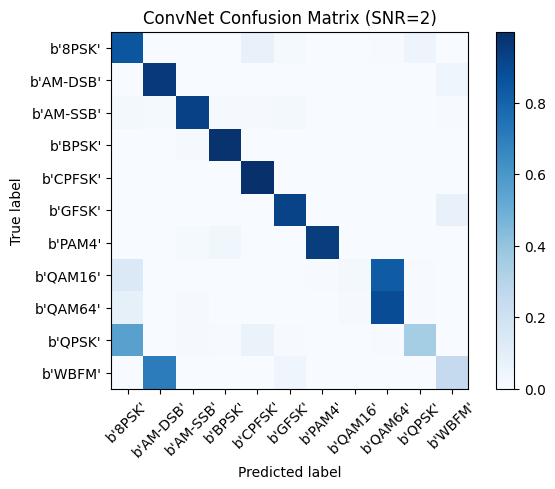

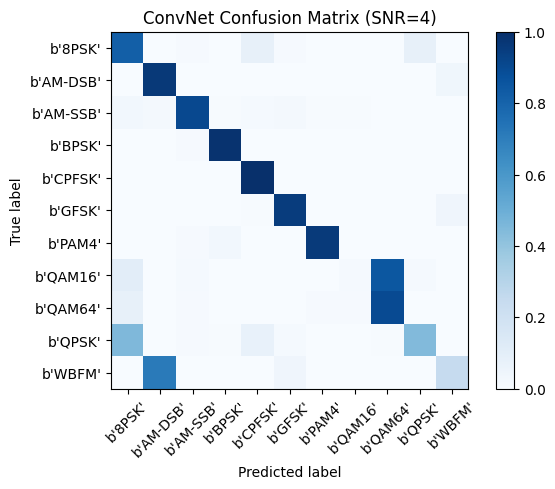

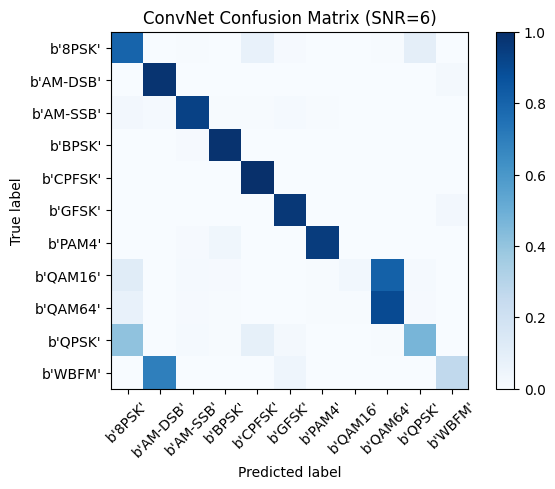

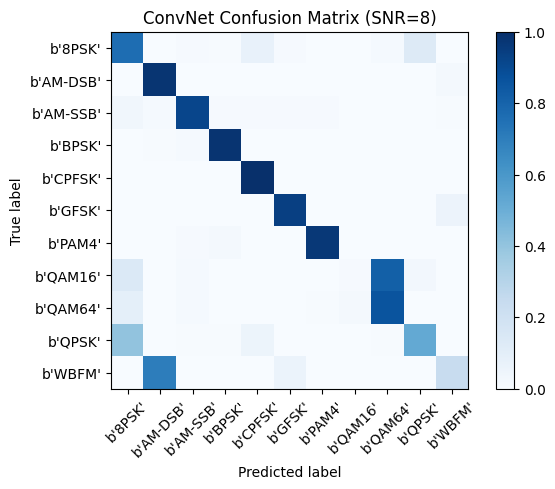

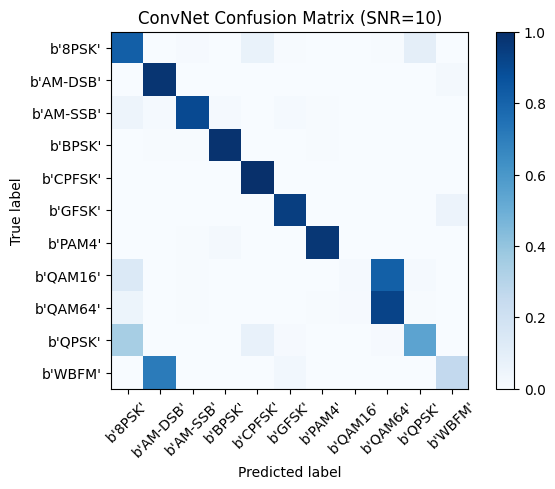

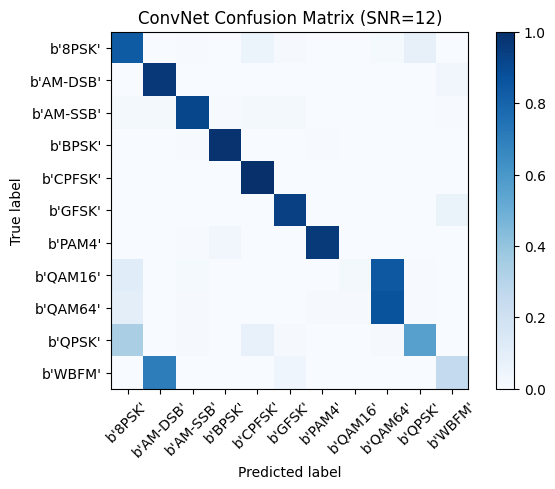

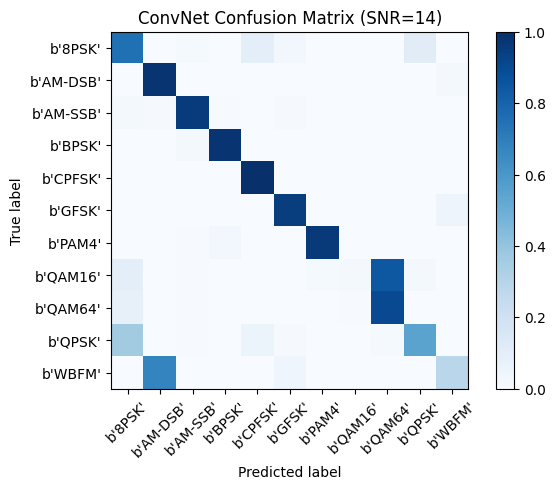

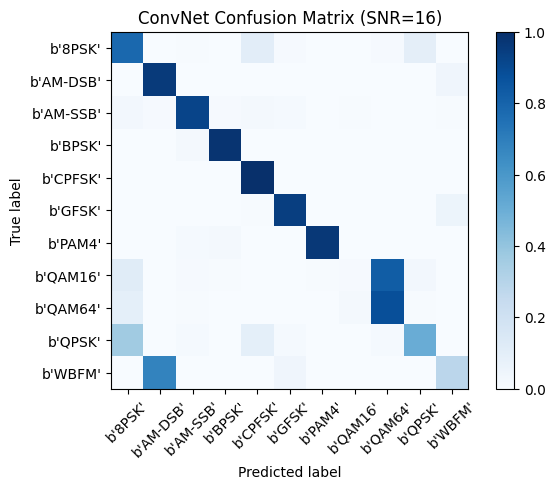

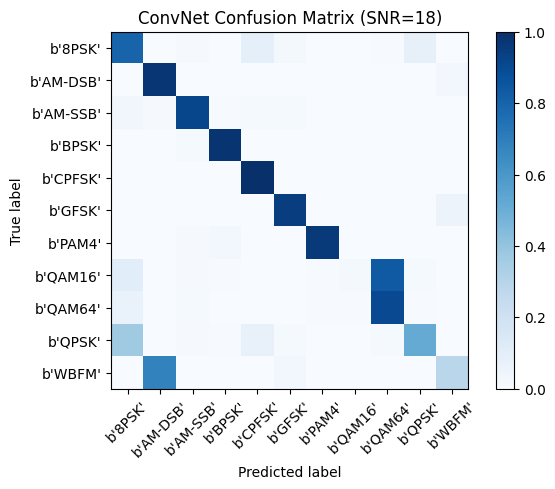

In [ ]:
acc = getTestAccArray(model, lbl, X_test, y_test, test_idx)

In [ ]:
# Save results to a pickle file for plotting later
fd = open('results_cnn_d0.5.dat','wb')
pickle.dump( ("CNN", 0.5, acc) , fd )

Text(0.5, 1.0, 'Accuracy vs SNRs')

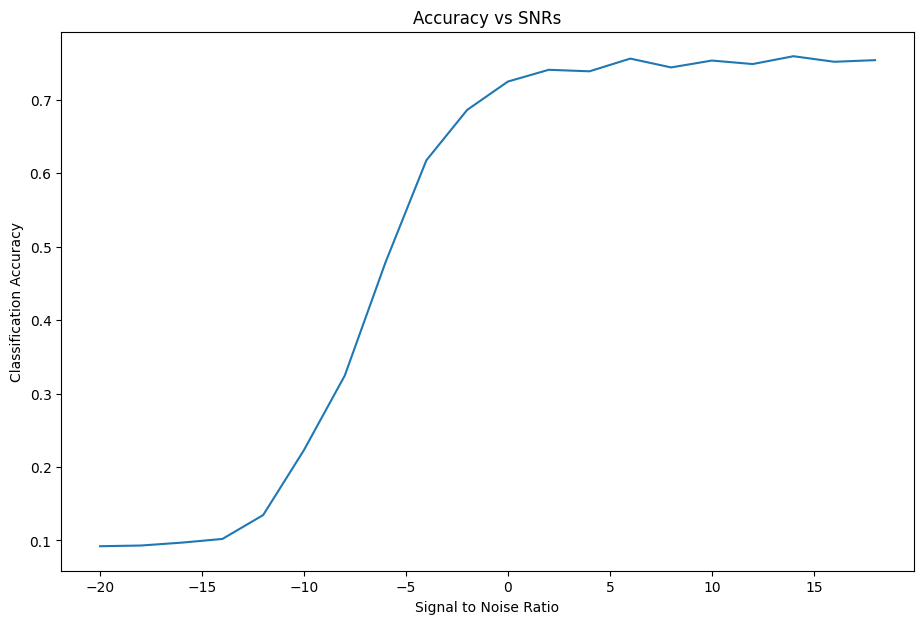

In [ ]:
# Plot accuracy curve
plt.figure(figsize = (11, 7))
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title('Accuracy vs SNRs')